In [1]:
%pylab inline
import emcee
from random import *
from observational_data import *
from constants import *
from functions import *
import numpy as np
import time

Populating the interactive namespace from numpy and matplotlib


In [16]:
def initial_positions(nwalkers):
    """Initial position of Random Walkers
    
    Uses four gaussians to generate random inital parameters."""
    mult= 1.
    p = []
    K0 = k0*mult
    K1 = k1*mult
    K2 = k2*mult
    K3 = k3*mult

    for i in range(nwalkers):
        L_0R   = L_0in  *10**(gauss(0.0,K0))
        M_0R   = M_0in  *10**(gauss(0.0,K1))
        betaR  = betain + gauss(0.0,K2)
        gammaR = gammain+ gauss(0.0,K3)    
    
    ### Some constraints over parameters
        while (L_0R <10**(16.75)) or (L_0R >10**(19.0)):
            L_0R   = L_0in  *10**(gauss(0.0,K0))
        while (M_0R < 10**10.50) or (M_0R > 10**12.00):
            M_0R   = M_0in  *10**(gauss(0.0,K1))
        while (betaR<0) or (betaR>1.6):
            betaR  = betain + gauss(0.0,K2)
        while (gammaR<0) or (gammaR>0.9):
            gammaR = gammain+ gauss(0.0,K3)            
        
        p.append(array([L_0R, M_0R, betaR, gammaR]))        
    return p          



def lnprob( X, Mass, DataSets ):   #X = [M, L_0, M_0, beta, gamma]
    """ Likelihood function.
    
    Inputs: 
        X = [L_0, M_0, beta, gamma]
        M : Mass Catalog
        DataSets: The set of observations to fit. Example [OD1,OD3]
    """
    L_0   = X[0]
    M_0   = X[1]
    beta  = X[2]
    gamma = X[3]
    
    #print "beta= ", beta, ", gamma= ", gamma
    ### Restriction over parameters
    if (gamma<0)|(gamma>2.0):
        return -numpy.inf
    if (beta<0)|(beta>1.6):
        return -numpy.inf
    if (L_0<0):
        return -numpy.inf
    if (M_0<0):
        return -numpy.inf
    
    ### Create Luminosity Catalog from Halo Mass Catalog and parameters
    L   =   np.zeros(Mass.size)
    L[:]= Luminosity(Mass[:], L_0, M_0, beta, gamma)
    
    #index = np.where(L<0)[0]
    #if len(index)!=0:
    #    print L[index], X
    #    return -numpy.inf
    
    ### Create the Magnitude Catalog with/without dust attenuation
    Mag = 51.82 - 2.5 * log10(L)
    if (Dust_Ext == 1):
        Mag[Mag < Mag0] = ( Mag[Mag< Mag0]-4.61455)/1.2587
    
    ### Create histograms & Normalize the histograms
    HISTO = []
    
    for DS in DataSets:
        BoxLength = DS[4]
        aux = 1.0*np.histogram(Mag, bins= array(DS[1]) )[0]
        
        for i in range(len(aux)):
            if (aux[i]==0):     # guarantee a big error if the bin is zero
                aux[i] = 0.0000001
            aux[i] = aux[i]/( (DS[1][i+1] - DS[1][i] ) * BoxLength**3)
        HISTO.append(aux)
    
    ### Calcule Chi Square using number of Degrees of Freedom
    chi_sqr = 0.0
    for i in range(len(HISTO)):
        for j in range(HISTO[i].size):
            chi_sqr = chi_sqr + 0.5*( (log10(HISTO[i][j]) -log10(DataSets[i][0][1][j])) / DataSets[i][2][j])**2
            #print HISTO[i][j], DataSets[i][0][1][j]
           
    return -chi_sqr

In [17]:
### main
DATA = 1 ## From the set of boxes
STR = '../data/MD_3840_Planck1/BDM/Small_Cells/'+str(DATA)+'.dat'
M = np.loadtxt(STR,usecols=(3,), skiprows=0)
########## Halo mass must be divided by the Hubble Parameter ###
M = M/hpl                                                      #
################################################################


DataSets=[OD2]
ndim     = 4
nwalkers = 8*2*2
nstepsburn=100
#nstepsrun = 100
#Initial set of positions for the walkers
p0 = initial_positions(nwalkers) #(initial guess)

# Initialize the sampler with the chosen specs.
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[M, DataSets],threads=8) #to use 8 processors

t0 = time.time()

pos, prob, state = sampler.run_mcmc(p0, nstepsburn)

tf = time.time(); 
print "Burning steps: ", nstepsburn, "\nNumber of Walkers: ", nwalkers,
print "\nBurning time: ", tf - t0, " seconds"
print("Mean acceptance fraction: {0:.3f}".format(mean(sampler.acceptance_fraction)))



#sampler.reset()
#t0 = time.time()
#pos, prob, state = sampler.run_mcmc(p0, nstepsburn)
#tf = time.time(); 
#print "Running steps: ", nstepsrun, "\nNumber of Walkers: ", nwalkers,
#print "\nRunning time: ", tf - t0, " seconds"
#print("Mean acceptance fraction: {0:.3f}".format(mean(sampler.acceptance_fraction)))
    


Burning steps:  100 
Number of Walkers:  32 
Burning time:  22.782405138  seconds
Mean acceptance fraction: 0.266


(array([ 606,  811, 1003,  565,   76,   10,  104,    6,   10,    9]),
 array([ 0.01622368,  0.21041944,  0.40461521,  0.59881097,  0.79300674,
         0.9872025 ,  1.18139826,  1.37559403,  1.56978979,  1.76398556,
         1.95818132]),
 <a list of 10 Patch objects>)

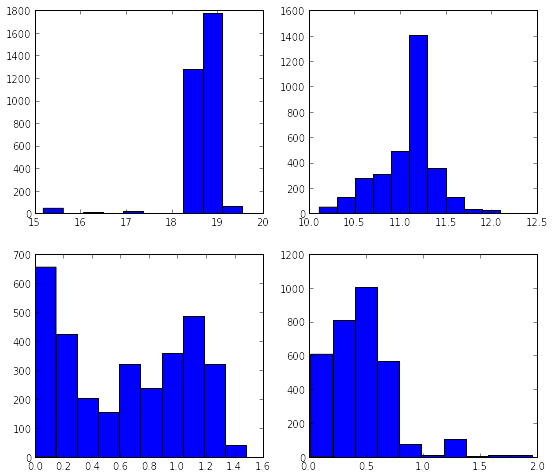

In [13]:
fig = figure(figsize=[9,8])
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.hist(log10(sampler.flatchain[:,0]), 10)
ax2.hist(log10(sampler.flatchain[:,1]), 10)
ax3.hist(sampler.flatchain[:,2], 10)
ax4.hist(sampler.flatchain[:,3], 10)


In [18]:
import triangle

In [20]:
sampler.chain.shape

(32, 100, 4)

In [21]:
samples = sampler.chain[:,32:,:].reshape((-1,ndim))

In [23]:
samples.shape

(2176, 4)

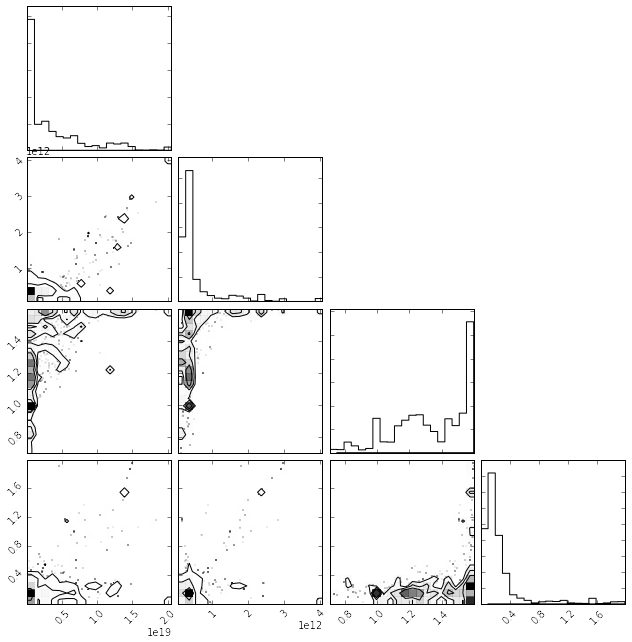

In [24]:
fig = triangle.corner(samples)

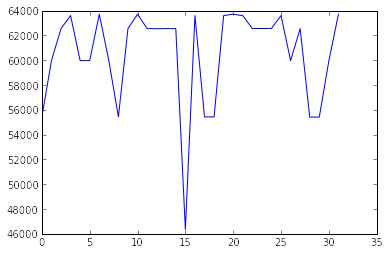

In [14]:
plot(prob)

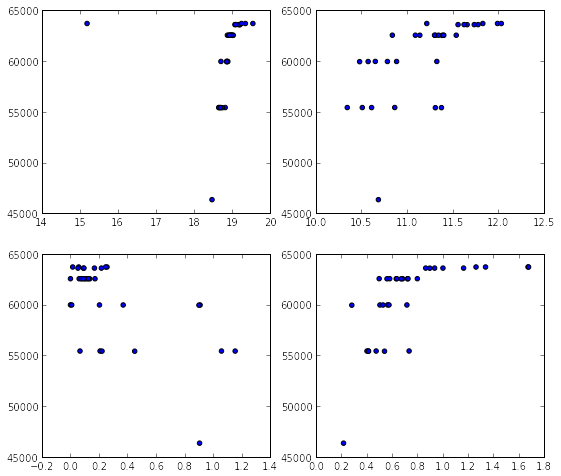

In [15]:
fig = figure(figsize=[9,8])
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.scatter(log10(pos[:,0]),(prob))
ax2.scatter(log10(pos[:,1]),(prob))
ax3.scatter(pos[:,2],(prob))
ax4.scatter(pos[:,3],(prob))



In [7]:
OD1

[array([[ -2.25000000e+01,  -2.20000000e+01,  -2.15000000e+01,
          -2.10000000e+01,  -2.05000000e+01],
        [  2.66000000e-08,   2.18000000e-06,   1.45000000e-05,
           1.29000000e-04,   2.30000000e-04],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00],
        [  2.50000000e-01,   2.50000000e-01,   2.50000000e-01,
           2.50000000e-01,   2.50000000e-01]]),
 [-22.75, -22.25, -21.75, -21.25, -20.75, -20.25],
 array([ 0.46679579,  0.39893724,  0.70197551,  0.26178501,  0.39138096]),
 'Willott']

In [9]:
OD2

[array([[ -2.25200000e+01,  -2.20200000e+01,  -2.15200000e+01,
          -2.10200000e+01,  -2.05200000e+01,  -2.00200000e+01,
          -1.95200000e+01,  -1.87700000e+01,  -1.77700000e+01,
          -1.67700000e+01],
        [  4.00000000e-06,   2.20000000e-05,   5.80000000e-05,
           1.20000000e-04,   2.93000000e-04,   5.93000000e-04,
           1.22200000e-03,   1.72000000e-03,   5.84000000e-03,
           9.42000000e-03],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00],
        [  2.50000000e-01,   2.50000000e-01,   2.50000000e-01,
           2.50000000e-01,   2.50000000e-01,   2.50000000e-01,
           2.50000000e-01,   5.00000000e-01,   5.00000000e-01,
           5.00000000e-01]]),
 [-22.7,
  -22.27,
  -21.77,
  -21.27,
  -20.77,
  -20.27,
  -19.77,
  -19.27,
  -18.27,
  -17.27,
  -16.27],
 array([ 0.42254902,

In [10]:
OD3

[array([[ -2.21200000e+01,  -2.17500000e+01,  -2.15000000e+01,
          -2.12500000e+01,  -2.10000000e+01,  -2.07500000e+01],
        [  1.30016958e-06,   7.99834255e-06,   1.23026877e-05,
           3.44349931e-05,   6.88652296e-05,   1.20781384e-04],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  2.50000000e-01,   2.50000000e-01,   2.50000000e-01,
           2.50000000e-01,   2.50000000e-01,   2.50000000e-01]]),
 [-22.38, -21.87, -21.62, -21.37, -21.12, -20.87, -20.63],
 array([ 0.565 ,  0.244 ,  0.199 ,  0.118 ,  0.0895,  0.0935]),
 'McLure']

In [2]:
OD4

[array([[ -2.20000000e+01,  -2.15000000e+01,  -2.10000000e+01,
          -2.05000000e+01,  -2.00000000e+01,  -1.95000000e+01,
          -1.90000000e+01],
        [  9.10000000e-06,   3.38000000e-05,   7.03000000e-05,
           1.91000000e-04,   3.97000000e-04,   5.85800000e-04,
           8.37500000e-04],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00],
        [  2.50000000e-01,   2.50000000e-01,   2.50000000e-01,
           2.50000000e-01,   2.50000000e-01,   2.50000000e-01,
           2.50000000e-01]]),
 [-22.25, -21.75, -21.25, -20.75, -20.25, -19.75, -19.25],
 array([ 0.22712919,  0.1216416 ,  0.08513086,  0.05434246,  0.04100839,
         0.03554075,  0.04502899]),
 'Finkelstein']

In [21]:
OD3[1]

[-22.38, -21.87, -21.62, -21.37, -21.12, -20.87, -20.63]